 # Learning about network behavior with Mahi-Mahi
 
 ## Summary
 
[mahimahi](http://mahimahi.mit.edu/) is a tool that allows network protocol developers to test different network conditions on a single machine. It comes with a bunch of options to spin up lightweight network containers that have links with different qualities. For instance, if you want to to test a link with a particular network delay, bandwidth, or queue size, you can do that quite easily.
 
This jupyter notebook uses mahimahi to demonstrate how network traffic operates under different conditions.
 
The logic behind the setup here was inspired by work done in developing [indigo](https://github.com/StanfordSNR/indigo/tree/master/env), a reinforcement learning-based congestion control algorithm.
 
 ## Installation
 
 I've only tested this on Ubuntu--if you are using MacOS or another operating system, I highly suggest using [Vagrant](https://www.vagrantup.com) to spin up a VM.
 
 ```bash
$ sudo apt-get update
$ sudo apt-get install mahimahi python-pip -y
$ sudo apt-get install python3-pip
$ pip3 install jupyter

$ # This needs to run every time you restart the computer
$ sudo sysctl -w net.ipv4.ip_forward=1
 ```
 
 ## Usage
 
Scroll down to the bottom of the notebook to see full examples, but here's a quick start:

```python

mahimahi_settings = {
    'delay': 100,
    'queue_size': 1,
    'trace_file': TRACE_FILES['114.68MBPS']
}

run_with_mahi_settings(mahimahi_settings, 10)
```

The `run_with_mahi_settings` function takes some settings, notably a `delay`, `queue_size`, and `trace_file`, along with a number of seconds that it should run for, and then prints out some statistics on what happened. What this does is create a single sender/receiver pair that send UDP packets to one another over the mahimahi boundary.

This UDP connection, while not actually TCP, is a decent way of simulating how TCP would perform over those
network conditions.

 
 ## More Details
 
 ### Trace Files
 
 The trace files were taken from [this repo](https://github.com/StanfordSNR/indigo/tree/master/env)
 
 This repository comes with a number of trace files in the `traces/` folder. These were taken from [this repo](https://github.com/StanfordSNR/indigo/tree/master/env). Each of these is a list of timestamps
 at which the link can send a 1500 byte packet, and it is used to set the bandwidth of the network. For a 12mbps
 (1500 bytes), it would contain numbers matching:
 
 ```
 1
 2
 3
 4
 ...
 ```
 
 ## TODO

I will be adding implementations of different congestion control algorithms here and comparing how each of them
does under different networking conditions.


In [1]:
import mpld3
import socket
import select
import json
import time
import matplotlib.pyplot as plt
from typing import Dict, List, Optional
from src.helpers import run_with_mahi_settings, get_open_udp_port
from src.senders import Sender
from src.strategies import SenderStrategy, FixedWindowStrategy

mpld3.enable_notebook()

In [2]:
TRACE_FILES = {
    '0.57MBPS': '0.57mbps-poisson.trace',
    '2.64MBPS': '2.64mbps-poisson.trace',
    '3.04MBPS': '3.04mbps-poisson.trace',
    '100.42MBPS': '100.42mbps.trace',
    '114.68MBPS': '114.68mbps.trace'
}

In [3]:
# class RenoSender(Sender):
#     def __init__(self, slow_start_thresh: int, initial_cwnd: int, port: int) -> None:
#         self.initial_cwnd = initial_cwnd
#         self.cwnd = initial_cwnd
#         self.slow_start_thresh = slow_start_thresh

#         super().__init__(port)
        
#     def window_is_open(self):
#         # Returns true if the congestion window is not full
#         return self.seq_num - self.next_ack < self.cwnd

#     def send(self):
#         serialized_data = json.dumps({
#             'seq_num': self.seq_num,
#             'send_ts': time.time(),
#             'sent_bytes': self.sent_bytes
#         })
#         self.unacknowledged_packets[self.seq_num] = True
#         self.seq_num += 1
#         self.sock.sendto(serialized_data.encode(), self.peer_addr)
#         time.sleep(0)
    
#     def recv(self):
#         serialized_ack, addr = self.sock.recvfrom(1600)

#         ack = json.loads(serialized_ack.decode())
#         if ack.get('handshake'):
#             return
        
#         self.total_acks += 1
#         self.times_of_acknowledgements.append(((time.time() - self.start_time), ack['seq_num']))

#         if self.unacknowledged_packets.get(ack['seq_num']) is None:
#             # Duplicate ack

#             self.num_duplicate_acks += 1
#             self.curr_duplicate_acks += 1
            
#             if self.curr_duplicate_acks == 3:
#                 # Received 3 duplicate acks, retransmit

#                 self.seq_num = ack['seq_num'] + 1
#                 self.slow_start_thresh = self.cwnd/2
#                 self.cwnd = self.slow_start_thresh
#         else:
#             self.curr_duplicate_acks = 0
#             del self.unacknowledged_packets[ack['seq_num']]
#             self.next_ack = max(self.next_ack, ack['seq_num'] + 1)
#             self.sent_bytes += ack['ack_bytes']
#             rtt = float(time.time() - ack['send_ts'])
#             self.rtts.append(rtt)
#             if self.cwnd < self.slow_start_thresh:
#                 # In slow start
#                 self.cwnd += 1 
#             elif ack['seq_num'] % self.cwnd == 0:
#                 # In congestion avoidance
#                 self.cwnd += 1
    
#         self.cwnds.append(self.cwnd) 

In [19]:
BETA_CUBIC = 0.7

class CubicStrategy(SenderStrategy):
    def __init__(self, c: float) -> None:
        self.c = c
        self.cwnd = 2
        self.slow_start_thresh = 42

        # List of tuples of ack_time and seq_num

        self.fast_retransmit_packet = None
        self.time_since_retransmit = None
        self.retransmitting_packet = False

        self.duplicated_ack = None
        
        self.w_max = self.slow_start_thresh
        self.congestion_avoidance_began_at = None
        self.ack_count = 0
        self.slow_start_thresholds = []

        super().__init__()

    def window_is_open(self) -> bool:
        # Returns true if the congestion window is not full

        return self.seq_num - self.next_ack < self.cwnd

    def next_packet_to_send(self) -> Optional[str]:
        send_data = None
        if self.retransmitting_packet and time.time() - self.time_of_retransmit > 1:
            print("Doing another retransmit of %d" % self.fast_retransmit_packet['seq_num'])
            self.retransmitting_packet = False

        if self.fast_retransmit_packet and not self.retransmitting_packet:
            
            print("Doing a retransmit of %d" % self.fast_retransmit_packet['seq_num'])
            self.unacknowledged_packets[self.fast_retransmit_packet['seq_num']]['send_ts'] = time.time()
            send_data = self.fast_retransmit_packet
            send_data['is_retransmit'] = True
            serialized_data = json.dumps(send_data)
            self.retransmitting_packet = True

            self.time_of_retransmit = time.time()

        elif self.window_is_open():
            send_data = {
                'seq_num': self.seq_num,
                'send_ts': time.time(),
                'sent_bytes': self.sent_bytes,
                'cwnd': self.cwnd,
                'is_retransmit': False
            }

            self.unacknowledged_packets[self.seq_num] = send_data
            self.seq_num += 1
        else:
            for seq_num, segment in self.unacknowledged_packets.items():
                if time.time() - segment['send_ts'] > 4:
                    self.unacknowledged_packets[seq_num]['send_ts'] = time.time()
                    segment['is_retransmit'] = True
                    print("%d timed out, retransmitting" % seq_num)
                    return json.dumps(segment)

        if send_data is None:
            return None
        else:
            return json.dumps(send_data)


    def compute_w_est(self) -> int:
        average_rtt = sum(self.rtts)/len(self.rtts)
        
        return (
            self.w_max * BETA_CUBIC + (
              ((3*(1 - BETA_CUBIC)) * (
                  (time.time() - self.congestion_avoidance_began_at)/average_rtt) ) /(1 + BETA_CUBIC)
            )
        )
    
    def compute_w_cubic(self, t: float) -> int:

        k = (self.w_max * ((1 - BETA_CUBIC)/self.c)) ** (1/3)
        print("k: %d, t: %f, w_max: %d" % (k, t, self.w_max))
        return self.c * (((t)-k) ** 3) + self.w_max
    
    def average_rtt(self):
        return sum(self.rtts)/len(self.rtts)
    
    def process_ack(self, serialized_ack: str) -> None:

        ack = json.loads(serialized_ack)
        if ack.get('handshake'):
            return

        self.total_acks += 1
        self.times_of_acknowledgements.append(((time.time() - self.start_time), ack['seq_num']))


        if self.unacknowledged_packets.get(ack['seq_num']) is None:
            # Duplicate ack

            self.num_duplicate_acks += 1
            if self.duplicated_ack and ack['seq_num'] == self.duplicated_ack['seq_num']:
                self.curr_duplicate_acks += 1
            else:
                self.duplicated_ack = ack
                self.curr_duplicate_acks = 1

            if self.curr_duplicate_acks == 3:
                # Received 3 duplicate acks, retransmit
                self.fast_retransmit_packet = self.unacknowledged_packets[ack['seq_num'] + 1]
                print("HIT A DROP OF PACKET %d" % (ack['seq_num'] + 1))
                self.w_max = self.cwnd
                self.slow_start_thresh = max(2, self.cwnd * BETA_CUBIC)
                self.cwnd = self.cwnd * BETA_CUBIC
        elif ack['seq_num'] >= self.next_ack:
            if self.fast_retransmit_packet:
                self.fast_retransmit_packet = None
                self.retransmitting_packet = False
                self.curr_duplicate_acks = 0
                self.seq_num = ack['seq_num'] + 1
                print("Recovering from fast retrasmit w/ seq_num %d" % ack['seq_num'])
                # Acknowledge all packets where seq_num < ack['seq_num']
                # Throw out all unacknowledged packets and start over

            # Acknowledge all packets where seq_num < ack['seq_num']
            self.unacknowledged_packets = {
                k:v
                for k,v in
                self.unacknowledged_packets.items()
                if k > ack['seq_num']
            }
            self.next_ack = max(self.next_ack, ack['seq_num'] + 1)
            self.sent_bytes += ack['ack_bytes']
            self.ack_count += 1
            rtt = float(time.time() - ack['send_ts'])
            self.rtts.append(rtt)
            if self.congestion_avoidance_began_at is None and self.cwnd >= self.slow_start_thresh:
                self.congestion_avoidance_began_at = time.time()
            
            if self.cwnd < self.slow_start_thresh:
                self.congestion_avoidance_began_at = None
                # In slow start
                self.cwnd += 1

            else:
                # In congestion avoidance
                w_est = self.compute_w_est()
                t = (time.time() - self.congestion_avoidance_began_at)
                w_cubic = self.compute_w_cubic(t)
                
                if w_cubic > w_est:
                    a = (self.compute_w_cubic(t + self.average_rtt()) - self.cwnd)/self.cwnd 
                    print("a: %f" % a)
                    self.cwnd += a
                else:
                    self.cwnd = w_est


        self.cwnds.append(self.cwnd)
        self.slow_start_thresholds.append(self.slow_start_thresh)


In [24]:
TIMEOUT = 2

class TahoeStrategy(SenderStrategy):
    def __init__(self, slow_start_thresh: int, initial_cwnd: int) -> None:
        self.slow_start_thresh = slow_start_thresh

        self.cwnd = initial_cwnd
        self.fast_retransmit_packet = None
        self.time_since_retransmit = None
        self.retransmitting_packet = False
        self.ack_count = 0
        
        self.fast_retransmitted_packets_in_flight = []
        
        self.duplicated_ack = None
        self.slow_start_thresholds = []

        super().__init__()

    def window_is_open(self) -> bool:
        # next_ack is the sequence number of the next acknowledgement
        # we are expecting to receive. If the gap between next_ack and
        # seq_num is greater than the window, then we need to wait for
        # more acknowledgements to come in.
        return self.seq_num - self.next_ack < self.cwnd

    def next_packet_to_send(self) -> Optional[str]:
        send_data = None
        in_greater_than_one_retransmit = False
        if self.retransmitting_packet and self.time_of_retransmit and time.time() - self.time_of_retransmit > 1:
            # The retransmit packet timed out--resend it
            print("Retransmitting > 1 time")
            self.retransmitting_packet = False
            in_greater_than_one_retransmit = True

        if self.fast_retransmit_packet and not self.retransmitting_packet:
            # Logic for resending the packet
            self.unacknowledged_packets[self.fast_retransmit_packet['seq_num']]['send_ts'] = time.time()
            send_data = self.fast_retransmit_packet
            send_data['is_retransmit'] = True
            serialized_data = json.dumps(send_data)
            self.retransmitting_packet = True
            if in_greater_than_one_retransmit:
                print("Retransmitting > 1 time")
            print("retransmitting %d" % (self.fast_retransmit_packet['seq_num']))
            self.time_of_retransmit = time.time()

        elif self.window_is_open():
            send_data = {
                'seq_num': self.seq_num,
                'send_ts': time.time(),
                'cwnd': self.cwnd,
                'is_retransmit': False
            }

            self.unacknowledged_packets[self.seq_num] = send_data
            self.seq_num += 1
        elif not self.fast_retransmit_packet:
            # Check to see if any segments have timed out. Note that this
            # isn't how TCP actually works--traditional TCP uses exponential
            # backoff for computing the timeouts
            for seq_num, segment in self.unacknowledged_packets.items():
                if seq_num < self.seq_num and time.time() - segment['send_ts'] > TIMEOUT:   
                    print("Timedout packet id: %d" % seq_num)
                    segment['send_ts'] = time.time()
                    segment['is_retransmit'] = True
                    self.slow_start_thresh = int(max(1, self.cwnd/2))
                    self.cwnd = 1

                    self.fast_retransmitted_packets_in_flight.append(seq_num)
                    self.fast_retransmit_packet = segment
                
                    return json.dumps(segment)

        if send_data is None:
            return None
        else:
            return json.dumps(send_data)


    def process_ack(self, serialized_ack: str) -> None:
        ack = json.loads(serialized_ack)
        if ack.get('handshake'):
            return

        self.total_acks += 1
        self.times_of_acknowledgements.append(((time.time() - self.start_time), ack['seq_num']))


        if self.unacknowledged_packets.get(ack['seq_num']) is None:
            # Duplicate ack

            self.num_duplicate_acks += 1
            if self.duplicated_ack and ack['seq_num'] == self.duplicated_ack['seq_num']:
                self.curr_duplicate_acks += 1
            else:
                self.duplicated_ack = ack
                self.curr_duplicate_acks = 1

            if self.curr_duplicate_acks == 3 and (ack['seq_num'] + 1) not in self.fast_retransmitted_packets_in_flight:
                # Received 3 duplicate acks, retransmit
                self.fast_retransmitted_packets_in_flight.append(ack['seq_num'] + 1)
                print(self.fast_retransmitted_packets_in_flight)
                self.fast_retransmit_packet = self.unacknowledged_packets[ack['seq_num'] + 1]
                print("Lost packet id: %d" % (ack['seq_num'] + 1))
                self.slow_start_thresh = int(max(1, self.cwnd/2))
                self.cwnd = 1
        elif ack['seq_num'] >= self.next_ack:
            if self.fast_retransmit_packet is not None:
                self.fast_retransmit_packet = None
                self.retransmitting_packet = False
                self.curr_duplicate_acks = 0
                self.seq_num = ack['seq_num'] + 1
                
                print("Recovering from fast retrasmit w/ seq_num %d" % ack['seq_num'])
                self.fast_retransmitted_packets_in_flight = []
            else:
                # Acknowledge all packets where seq_num < ack['seq_num']
                self.unacknowledged_packets = {
                    k:v
                    for k,v in
                    self.unacknowledged_packets.items()
                    if k > ack['seq_num']
                }
            self.next_ack = max(self.next_ack, ack['seq_num'] + 1)
            self.seq_num = self.next_ack
            self.ack_count += 1
            self.sent_bytes = ack['ack_bytes']
            rtt = float(time.time() - ack['send_ts'])
            self.rtts.append(rtt)
            if self.cwnd < self.slow_start_thresh:
                # In slow start
                self.cwnd += 1
            elif (ack['seq_num'] + 1) % self.cwnd == 0:
                # In congestion avoidance
                self.cwnd += 1

        self.cwnds.append(self.cwnd)
        self.slow_start_thresholds.append(self.slow_start_thresh)

In [22]:
# Run this in the demo

# mpld3.enable_notebook()

# mahimahi_settings = {
#     'delay': 88,
#     'queue_size': 1104620,
#     'trace_file': TRACE_FILES['100.42MBPS']
# }
# port = get_open_udp_port()
# strat = CubicStrategy(0.4)
# plot = run_with_mahi_settings(mahimahi_settings, 20, [Sender(port, strat)])

[sender] Connected to receiver: 100.64.0.6:43126

Timedout packet id: 13084
retransmitting 13084
Retransmitting > 1 time
Retransmitting > 1 time
retransmitting 13084
Recovering from fast retrasmit w/ seq_num 13084
[41297]
Lost packet id: 41297
retransmitting 41297
Recovering from fast retrasmit w/ seq_num 41297
Timedout packet id: 48542
retransmitting 48542
Retransmitting > 1 time
Retransmitting > 1 time
retransmitting 48542
Retransmitting > 1 time
Retransmitting > 1 time
retransmitting 48542
Recovering from fast retrasmit w/ seq_num 48542
Timedout packet id: 54478
retransmitting 54478
Retransmitting > 1 time
Retransmitting > 1 time
retransmitting 54478
Recovering from fast retrasmit w/ seq_num 54478
Results for sender 58596:
Total Acks: 62168
Num Duplicate Acks: 1310
% duplicate acks: 2.107193
Throughput (bytes/s): 40572.000000
Average RTT (ms): 8770.431708


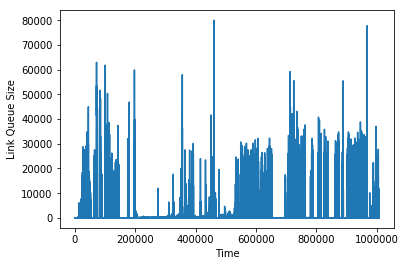

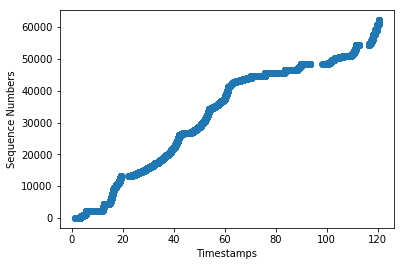

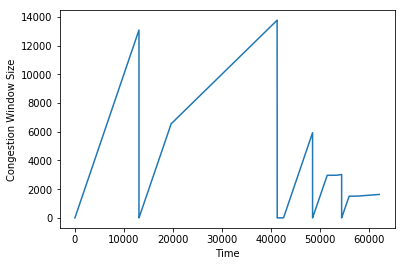

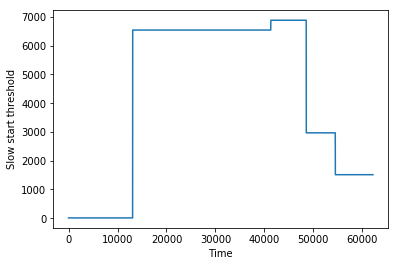

In [26]:

mahimahi_settings = {
    'delay': 88,
    'queue_size': 80000,
    'trace_file': TRACE_FILES['100.42MBPS']
}

port = get_open_udp_port()
port2 = get_open_udp_port()
strat = TahoeStrategy(10, 1)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])

[sender] Connected to receiver: 100.64.0.4:43803

[362]
Lost packet id: 362
retransmitting 362
Recovering from fast retrasmit w/ seq_num 362
[367]
Lost packet id: 367
retransmitting 367
Recovering from fast retrasmit w/ seq_num 367
[599]
Lost packet id: 599
retransmitting 599
Recovering from fast retrasmit w/ seq_num 599
[1586]
Lost packet id: 1586
retransmitting 1586
Recovering from fast retrasmit w/ seq_num 1602
[2272]
Lost packet id: 2272
retransmitting 2272
Recovering from fast retrasmit w/ seq_num 2275
[2820]
Lost packet id: 2820
retransmitting 2820
Recovering from fast retrasmit w/ seq_num 2826
[3464]
Lost packet id: 3464
retransmitting 3464
Recovering from fast retrasmit w/ seq_num 3482
[3891]
Lost packet id: 3891
retransmitting 3891
Recovering from fast retrasmit w/ seq_num 3891
[5126]
Lost packet id: 5126
retransmitting 5126
Recovering from fast retrasmit w/ seq_num 5126
[6015]
Lost packet id: 6015
retransmitting 6015
Recovering from fast retrasmit w/ seq_num 6015
[6695]
Lost 

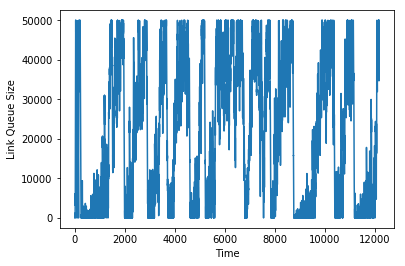

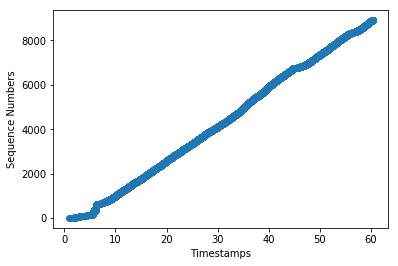

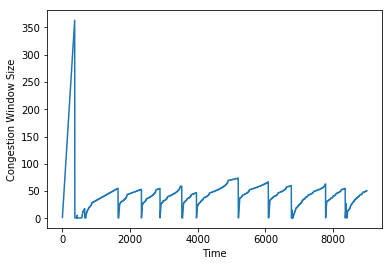

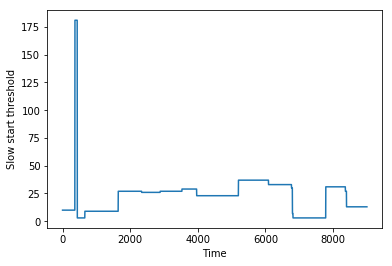

In [25]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 50000,
    'trace_file': TRACE_FILES['2.64MBPS']
}

port = get_open_udp_port()
strat = TahoeStrategy(10, 1)
run_with_mahi_settings(mahimahi_settings, 60, [Sender(port, strat)])

In [ ]:
mahimahi_settings = {
    'delay': 27,
    'queue_size': 173,
    'trace_file': TRACE_FILES['100.42MBPS']
}


In [ ]:
mahimahi_settings = {
    'delay': 45,
    'queue_size': 450,
    'trace_file': TRACE_FILES['114.68MBPS']
}


In [ ]:
# Absurd Queue Size case

mahimahi_settings = {
    'delay': 100,
    'queue_size': 1,
    'trace_file': TRACE_FILES['114.68MBPS']
}
